# Testing the Model

NOTE: This is the notebook file for testing the model AFTER training it. It does not contain any training code itself. Please verify there are model weights (e.g. `model-1.1046-48-.h5`) available in the `checkpoints/` folder. If not, run train.ipynb to train the network and generate the weights.

In [2]:
import numpy as np
import seaborn as sns
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os
tensorflow.config.list_physical_devices('GPU') # If this returns [], then GPU support is not set up. Training will be SLOWWWW!

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### First, we load the test data:
- Taken from the images/validation/ folder

In [12]:
# size of the image: 48*48 pixels
pic_size = 48

base_path = "./images/"

class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

def load_data(dataset="train", num_img=100000):
    images = []
    classes = []
    for expression in os.listdir(base_path + dataset):
        for img_file in os.listdir(base_path + dataset + "/" + expression)[:num_img]:
            img = load_img(base_path + dataset + "/" + expression + "/" + img_file, target_size=(pic_size, pic_size), color_mode='grayscale')
            images.append(img_to_array(img))
            classes.append(class_names.index(expression))

    return (np.array(images) / 255, np.array(classes))

x_test, y_test = load_data("validation") # using validation test data

np.random.seed(42)
np.random.shuffle(x_test)
np.random.seed(42)
np.random.shuffle(y_test)

x_test.shape

(7066, 48, 48, 1)

### Here we use the same model as in train.ipynb:

In [13]:
model = keras.models.Sequential()
#1st CNN layer
model.add(Conv2D(64,(5,5),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
#2nd CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))

#3rd CNN layer
model.add(Conv2D(64,(2,2),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


# Fully connected 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected 3rd layer
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected 4th layer
model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected 5th layer
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(len(class_names), activation='softmax'))

keras.backend.clear_session()
np.random.seed(42)
tensorflow.random.set_seed(42)

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.00001), metrics=["accuracy"])

### Next, we load the best weights from the `checkpoints/` folder.

In [14]:
checkpoints = os.listdir('checkpoints')
if (len(checkpoints) > 0):
    checkpoints.sort()
    print("Loading " + checkpoints[0])
    model.load_weights('checkpoints/' + os.listdir('checkpoints')[-1]) # Load the best model so far
else:
    print("No model to load from")

Loading model-1.0438-945-.h5


### Next we can check the accuracy of the trained model:

In [15]:
model.evaluate(x_test, y_test)

221/221 [==============================] - 2s 5ms/step - loss: 1.1053 - accuracy: 0.6296


[1.1052628755569458, 0.6296348571777344]

### Finally, test with 30 random face images. Rerun this cell to generate a new set of faces.

1/1 [==============================] - 0s 30ms/step


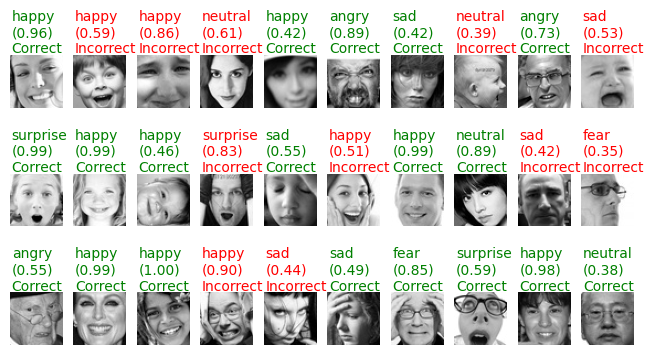

In [21]:
sampleIdxs = np.random.choice(len(x_test), 30)

x_example = x_test[sampleIdxs]
y_actual = y_test[sampleIdxs]

y_predicted: np.ndarray = model.predict(x_example)

pred_values = np.argmax(y_predicted, axis=1)

plt.tight_layout()
for i, img in enumerate(x_example):
    plt.subplot(3,10, i+1, )
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    match = y_actual[i] == pred_values[i]
    plt.text(1, -2, class_names[pred_values[i]] + "\n({:.2f})".format(y_predicted[i][pred_values[i]]) + "\n" + ("Correct" if match else "Incorrect"), color="green" if match else "red")

plt.subplots_adjust(bottom=0.2, right=1.1, top=0.9)
plt.show()

- Green text means that the model successfully predicted the expression, and red means it was wrong.
- The numbers given are the confidence values for each expression. (e.g, a 0.78 confidence value means the model was 78% confident that the emotion it picked was the right one)